### First rename this file by replacing "ID" with your "last_name_actual_id"

#### HWF-Python. Use this template to implement the following tasks:

#### Tasks:
#### 1. Read image data (ilk-3b-1024.tif) at the locations provided in the file (ilk-3b-1024-10k-pnts.csv)
#### ilk-3b-1024.tif contains 3 spectral bands, Width = 1024, Height = 1024
####
#### Generating training data: For this, use the sample location data from file ilk-3b-1024-10k-pnts.csv. This file contains 10k points, with format (ID, X, Y). Now, for each X, Y coordinate read pixel data (a vector of length 12) as a pandas dataframe.

#### removed attribute selection task, cheer up!

#### 2. For initial clustering you can use KMeans() function from sklearn library. To get yourself familiar, do clustering with K=10 and plot cluster data.

#### 3. Implement the "Algorithm 1" in the paper "Learning the k in k-means"

#### 4. Generate visualizations (plots) as asked in the cells.

#### Read each cell and write code as needed
#### Organize your clode logically, create new cells as needed
#### You are allowed to search for code snippet on the web for plotting, sklearn, etc., but code should be your own. You are not allowed to directly search for actual implementaion code of the the paper and use code for the same that may be freely available on the web and/or github repositories.
#### I have already removed attribue selection component to reduce your implementation time, so don't take any shortcuts!
#### Enjoy doing your first data science project.

In [1]:
! pip install rasterio

In [2]:
# import necessary libraries; don't change this cell, if you need any additional libraries, use next cell
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.windows import from_bounds
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
import sys
#
np.random.seed(100)

In [93]:
# if you need additional libraries, include them here
# make to include all your additional liberies here and not any other cells
from sklearn.decomposition import PCA
from scipy.stats import norm, anderson
from sklearn.preprocessing import StandardScaler

## Step 1: Prepare data (Generate training data)

In [4]:
# Read image: data/ilk-3b-1024.tif
# Hint: explore rasterio package

img_path = "ilk-3b-1024.tif"

rgb_img = rio.open(img_path)

### once successfully opened image, you can get meta data such as size, projection, etc.
### read rasterio documentation to learn more about the libarary and its functionality

In [5]:
print(rgb_img.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1024, 'height': 1024, 'count': 3, 'crs': CRS.from_epsg(26916), 'transform': Affine(1.0, 0.0, 394530.0,
       0.0, -1.0, 4620006.0), 'blockysize': 2, 'tiled': False, 'interleave': 'pixel'}


In [6]:
rgb_img.shape

(1024, 1024)

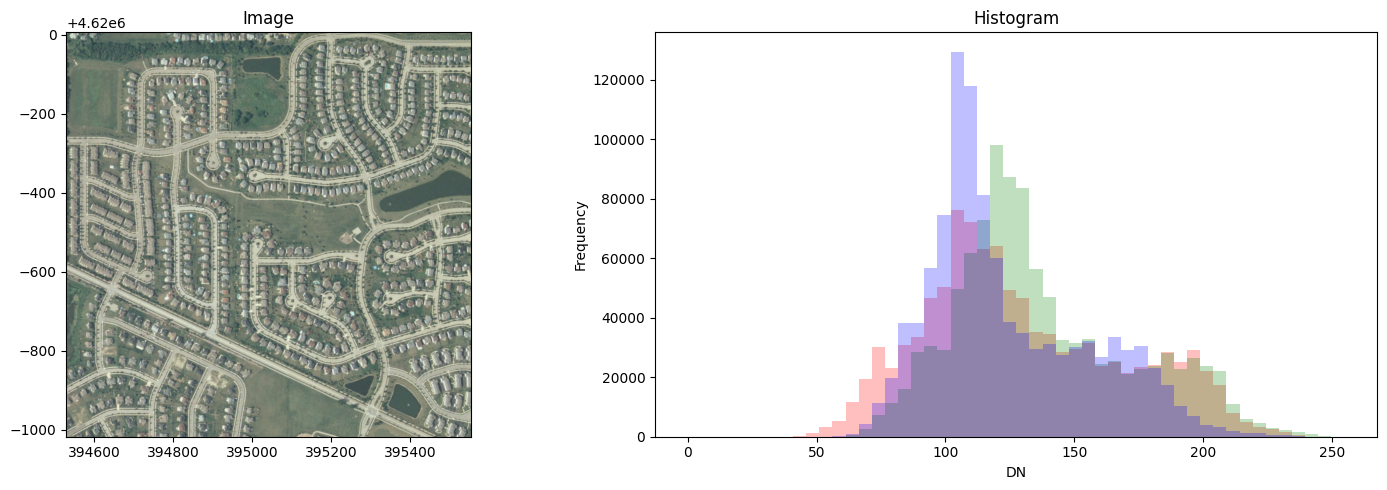

In [7]:
# visualize image data and its histogram (write your code here to generate figure similar to the one below
# Hint: you can explore matplotlib subplots, raterio.plot, etc

img_arr = rgb_img.read()

#Splitting image into rgb channels
red = img_arr[0]
green = img_arr[1]
blue = img_arr[2]

fig, axes = plt.subplots(1,2,figsize=(15,5))

#Plotting the Image
show(rgb_img, ax=axes[0])
axes[0].set_title('Image')


#Plotting histograms for R,G,B values
axes[1].hist(red.flatten(), bins=50, range=[0,255], color='red', alpha=0.25)
axes[1].hist(green.flatten(), bins=50, range=[0,255], color='green', alpha=0.25)
axes[1].hist(blue.flatten(), bins=50, range=[0,255], color='blue', alpha=0.25)
axes[1].set_title("Histogram")
axes[1].set_xlabel("DN")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Likewise, open csv file for reading sample locations

In [8]:
# read csv file containing sample locations: data/ilk-3b-1024-10k-pnts.csv
# hint, you can use pandas functions
csv_path = "ilk-3b-1024-10k-pnts.csv"
xydata = pd.read_csv(csv_path)

In [9]:
## once successfuly read csv file, examine the data to make sure everything is fine
## display top 5 rows here
xydata.head()

,id,X,Y
0,0,395141.5756,4619891.465
1,1,395267.6855,4619541.988
2,2,395177.9343,4619966.368
3,3,395444.7146,4619615.272
4,4,395236.0146,4619433.194


In [10]:
print(xydata.head())

   id            X            Y
0   0  395141.5756  4619891.465
1   1  395267.6855  4619541.988
2   2  395177.9343  4619966.368
3   3  395444.7146  4619615.272
4   4  395236.0146  4619433.194


In [11]:
xydata.describe()

,id,X,Y
count,10000.00000,10000.000000,1.000000e+04
mean,4999.50000,395042.964026,4.619498e+06
std,2886.89568,291.171868,2.927231e+02
min,0.00000,394536.668900,4.618991e+06
25%,2499.75000,394789.177300,4.619241e+06
50%,4999.50000,395041.552000,4.619502e+06
75%,7499.25000,395292.699275,4.619753e+06
max,9999.00000,395548.958000,4.620000e+06


In [12]:
len(xydata)

10000

In [13]:
# now you can read data from raster image for every x,y coordinate from the csv file
# Hint: explore rasterio image reading functions
# The code you write here should finally produce a panadas dataframe, say df

points = []

with rio.open(img_path) as image:
  for i in range(len(xydata)):
    row, col = image.index(xydata['X'][i], xydata['Y'][i])
    rgb = image.read([1,2,3], window=((row, row+1), (col, col+1)))
    points.append(rgb.flatten())

cols = ['R', 'G', 'B']

# convert the data you read (say into variable d) to a dataframe
df = pd.DataFrame(points, columns=cols)

In [14]:
# First name the columns in the dataframe as R, G, B.
# Then display image data (r, g, b) for first 5 points

df.head()

,R,G,B
0,74,86,86
1,106,120,105
2,155,163,154
3,76,92,86
4,209,213,187


In [15]:
# compute mean and standard deviation of each band,
# generate bargraphs, and show standard deviation on the bar plot

m = df.mean()
sd = df.std()

In [16]:
print("Means:\n", m)
print("SD:\n", sd)

Means:
 R    130.6914
G    138.0920
B    124.5246
dtype: float64
SD:
 R    39.133841
G    34.703386
B    31.192081
dtype: float64


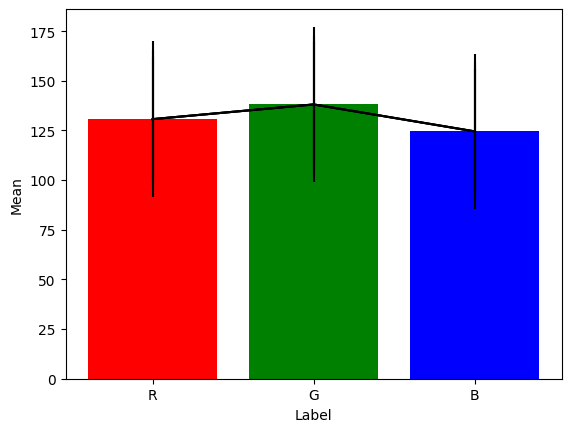

In [31]:
# write code to plot the means and standard deviations here

plt.bar(['R', 'G', 'B'], m, color=['red', 'green', 'blue'])

for i, mean in enumerate(m):
  plt.errorbar(['R', 'G', 'B'], m, yerr=sd[i], color='black', capsize=0)

plt.xlabel('Label')
plt.ylabel('Mean')
plt.show()

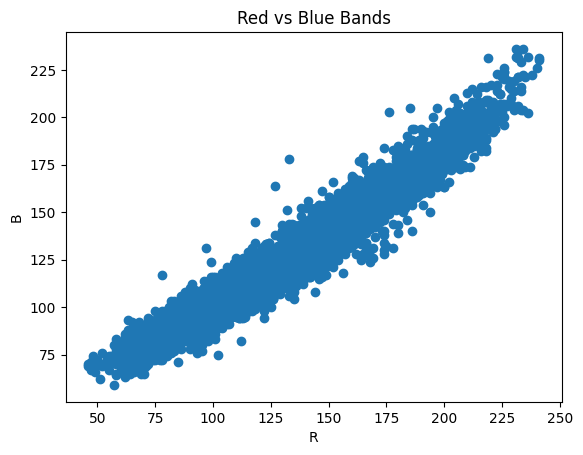

In [19]:
# visualize rgb data as scatter plot; select bands 1 and 3
# note image attributes are called bands (e.g., red, green, blue bands)
plt.scatter(df['R'], df['B'])
plt.title('Red vs Blue Bands')
plt.xlabel('R')
plt.ylabel('B')
plt.show()


## Done with Step 1

# Step 2: To get yourself familar with KMeans clustering, play with KMeans() clustering from scikit package

In [32]:
# k-means clustering using KMeans() from scikit-learn with K = 10

K = 10

# use km0 to store mode
km0 = KMeans(n_clusters=K)


# use y_km0 for storing predicted lables
y_km0 = km0.fit_predict(df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [37]:
# write code to print number of samples in each cluster

clusterId, numPoints = np.unique(y_km0, return_counts=True)
# clusterId, numPoints
pointsPerCluster = []
for i in range(len(clusterId)):
  ele = [clusterId[i], numPoints[i]]
  pointsPerCluster.append(ele)

print(pointsPerCluster)


[[0, 802], [1, 1595], [2, 842], [3, 768], [4, 1688], [5, 903], [6, 1207], [7, 816], [8, 288], [9, 1091]]


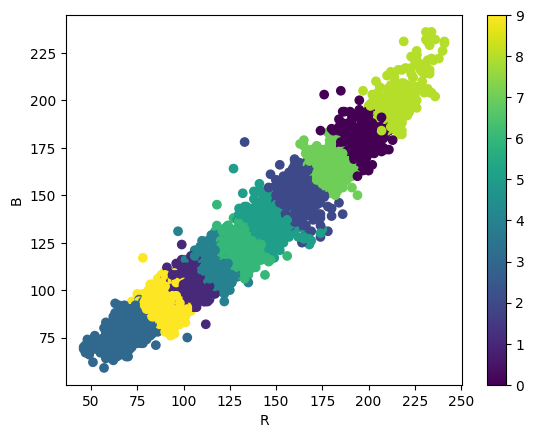

In [65]:
# visualize clusters as scatter plot

plt.scatter(df['R'], df['B'], c=y_km0)
plt.colorbar()
plt.xlabel('R')
plt.ylabel('B')
plt.show()

In [ ]:
# generate clustered image and display by writing code in the following cells

In [43]:
# read full image data
img = rgb_img.read()

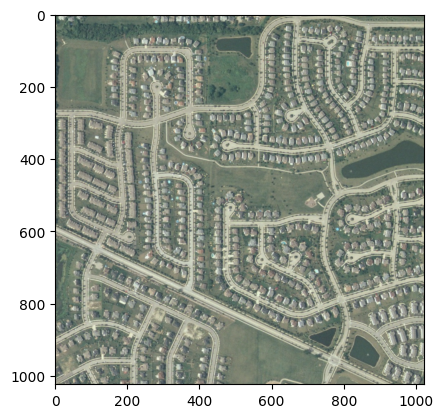

<Axes: >

In [44]:
# display image to check if you read the data correctly
show(img, cmap='viridis')

In [45]:
# note that the img data you read is ndarray, verify it
type(img)

numpy.ndarray

In [46]:
# and its shape should be (3, 1024, 1024)
print(img.shape)

(3, 1024, 1024)


In [55]:
# However, the clustering model prediction expects that the input to be r,g,b vectors
# So write code to convert image into rgb vectors

rgb_vec = img.transpose(1,2,0).reshape(-1,3)

In [56]:
# if you converted it correctly, you should get the shape of vector as (1048576, 3)
rgb_vec.shape

(1048576, 3)

In [58]:
# its good to verify that format of r, g, b, and actual values
# for example, first image pixel value should be (124, 129, 112)
rgb_vec[0]

array([124, 129, 112], dtype=uint8)

In [59]:
# predict label for each pixel (vector) by calling the predict method of KMeans() clustering

imgkm = km0.predict(rgb_vec)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


In [60]:
# Check the shape of the output, should be same as 1024 * 1024 = 1048576
imgkm.shape

(1048576,)

In [61]:
# you need to convert the is 1-D r,g,b vector back to image of 1024,1024 (note that its a single band image)
imgkm_out = imgkm.reshape(1024, 1024)

In [62]:
# check the shape
imgkm_out.shape

(1024, 1024)

In [63]:
type(imgkm_out)

numpy.ndarray

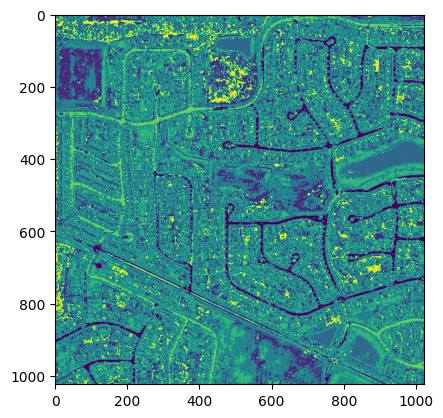

In [66]:
# plot the clustered image
plt.imshow(imgkm_out)

## End of Step 2

# Step 3: Implement the "Algorithm 1" in the paper "Learning the k in k-means"

In [ ]:
# implemention code for Algorithm 1
# Read the algorithm and the description in particular section 2.1
# You are allowed to use any Python library statstical functions like mean, standard deviation, variance, etc.
# create extra cells as needed, don't forget to comment each new cell you create

In [96]:
def check_for_normality(df, alpha=0.0001):
  res = anderson(df)
  n = len(df)
  stephens_correction = (1 + 4/n - 25/(n*n))
  res_corrected = res.statistic * stephens_correction

  res_alpha = res.significance_level/100.0
  cvs = res.critical_values

  nearest_ind = np.argmin(np.abs(res_alpha-alpha))
  nearest_alpha = res_alpha[nearest_ind]
  nearest_cv = cvs[nearest_ind]

  return res_corrected < nearest_cv

In [97]:
def child_centers_by_pca(cur_center, df):
  pca = PCA(n_components=1)
  pca.fit(df)
  s = pca.components_[0]
  eigenvalue = pca.explained_variance_[0]
  m = s*np.sqrt((2*eigenvalue)/np.pi)
  c1 = cur_center + m
  c2 = cur_center - m

  return c1, c2

In [101]:
# your algorith 1 clode goes here ...

def gmeans(df, alpha=0.0001, max_iters=250):
  init_centers = [np.mean(df, axis=0)]
  for i in range(max_iters):
    updated_centers = []
    for center in init_centers:
      c1, c2 = child_centers_by_pca(center, df)
      v = c1-c2

      projection = np.dot(df-np.mean(df, axis=0), v) / np.linalg.norm(v)
      scaler = StandardScaler()
      projection = scaler.fit_transform(projection.reshape(-1,1)).flatten()

      if check_for_normality(projection):
        updated_centers.append(center)
      else:
        km = KMeans(n_clusters=2, init=np.array([c1, c2])).fit(df)
        updated_centers.extend(km.cluster_centers_)

    if set(map(tuple, init_centers)) == set(map(tuple, updated_centers)):
      break

    init_centers = updated_centers

  return KMeans(n_clusters=len(init_centers), init=init_centers).fit(df)


In [ ]:
opt_clusters = gmeans(rgb_vec)

In [106]:
# print optimal number of clusters found with the algorithm
print("Optimal number of clusters is:", opt_clusters.n_clusters)

Optimal number of clusters is: 8


In [109]:
# print number of samples in each cluster
clusterId, numPoints = np.unique(opt_clusters.predict(rgb_vec), return_counts=True)

pointsPerCluster = []
for i in range(len(clusterId)):
  ele = [clusterId[i], numPoints[i]]
  pointsPerCluster.append(ele)

print("Number of points per cluster:", pointsPerCluster)

Number of points per cluster: [[0, 51292], [1, 161131], [2, 95003], [3, 180153], [4, 110230], [5, 235938], [6, 107646], [7, 107183]]


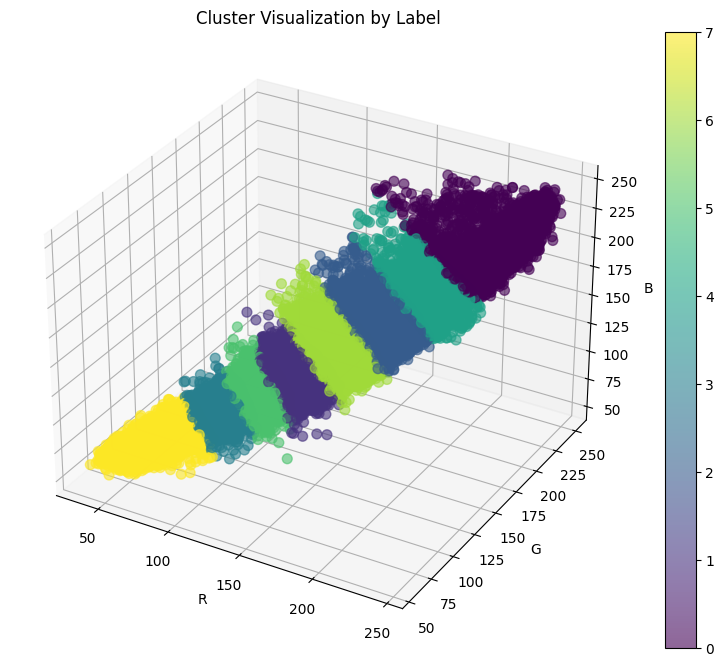

In [112]:
# generate scatter plot and color using cluster labels
figure = plt.figure(figsize=(10, 8))
ax = figure.add_subplot(111, projection='3d')
scatter_plot = ax.scatter(rgb_vec[:, 0], rgb_vec[:, 1], rgb_vec[:, 2], c=opt_clusters.labels_, s=50, alpha=0.6)
ax.set_title('Cluster Visualization by Label')
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
figure.colorbar(scatter_plot, ax=ax)
plt.show()

In [113]:
# Apply the final model to predict labels for each pixel in the image,
# that is, generate a clustered image

preds = opt_clusters.predict(rgb_vec)
image_clusters = preds.reshape(1024, 1024)

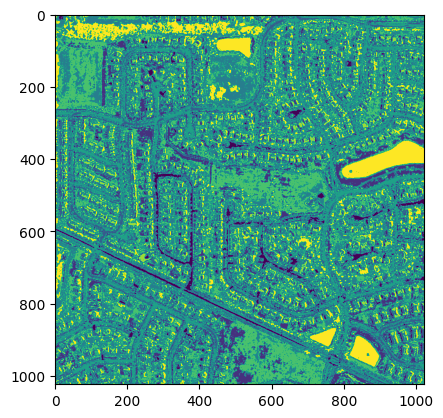

In [114]:
# display the clustered image here.
plt.imshow(image_clusters)
plt.show()